<a href="https://colab.research.google.com/github/dyx131313/ACS_random_noise_filtering/blob/main/random_noise_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KF filter with noise observation

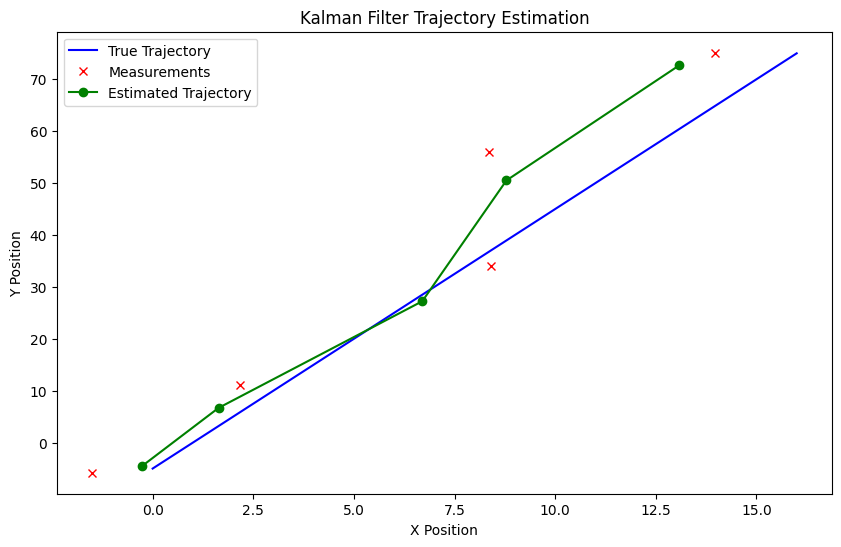

In [ ]:
# prompt: 仅利用numpy和matplotlib手动构建KF滤波器生成一段能预测点在二维平面上运动轨迹的代码，生成的真实轨迹的y值可以参考正弦函数,允许在状态中增加速度为状态量，把观测值也可视化，用英文作为可视化输出标题

import numpy as np
import matplotlib.pyplot as plt

# Time parameters
dt = 4  # Time step
T = 20  # Total time
num_steps = int(T / dt)

# State dimensionality
state_dim = 4  # Position (x, y) and velocity (vx, vy)

# System dynamics matrix (assuming constant velocity model)
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

# Control input matrix (assuming no control input)
B = None

# Measurement matrix (observing only position)
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# Process noise covariance
Q = 0.1 * np.eye(state_dim)

# Measurement noise covariance
R = 5 * np.eye(2)  # Assuming independent noise in x and y measurements

# Initial state estimate
x0 = np.array([0, 0, 1, 0])  # Initial position (0, 0) and velocity (1, 0)
P0 = np.eye(state_dim)  # Initial state covariance

# Generate true trajectory (y follows a sine wave)
t = np.arange(0, T, dt)
true_trajectory = np.zeros((state_dim, num_steps))
true_trajectory[0, :] = t  # x increases linearly with time
true_trajectory[1, :] = 5*t-5 # y follows a sine wave
true_trajectory[2, :] = 1  # Constant velocity in x
true_trajectory[3, :] = - 5  # Velocity in y is the derivative of sine

# Generate noisy measurements
measurements = H @ true_trajectory + np.random.multivariate_normal(np.zeros(2), R, num_steps).T

# Kalman Filter initialization
x_hat = x0
P = P0

# Store estimated trajectory and covariance
estimated_trajectory = np.zeros((state_dim, num_steps))
estimated_covariance = np.zeros((state_dim, state_dim, num_steps))

# Kalman Filter loop
for k in range(num_steps):
    # Prediction step
    if B is None:
        x_pred = A @ x_hat
    else:
        x_pred = A @ x_hat + B @ u  # Replace 'u' with actual control input if available
    P_pred = A @ P @ A.T + Q

    # Measurement update step
    y = measurements[:, k]
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_hat = x_pred + K @ (y - H @ x_pred)
    P = (np.eye(state_dim) - K @ H) @ P_pred

    # Store results
    estimated_trajectory[:, k] = x_hat
    estimated_covariance[:, :, k] = P

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(true_trajectory[0, :], true_trajectory[1, :], 'b-', label='True Trajectory')
plt.plot(measurements[0, :], measurements[1, :], 'rx', label='Measurements')
plt.plot(estimated_trajectory[0, :], estimated_trajectory[1, :], 'go-', label='Estimated Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Kalman Filter Trajectory Estimation')
plt.legend()
plt.show()


LSTM without noise observation, predicting few trajectory

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18, 2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Loss: 0.0027
Epoch [200/1000], Loss: 0.0027
Epoch [300/1000], Loss: 0.0027
Epoch [400/1000], Loss: 0.0027
Epoch [500/1000], Loss: 0.0028
Epoch [600/1000], Loss: 0.0028
Epoch [700/1000], Loss: 0.0027
Epoch [800/1000], Loss: 0.0027
Epoch [900/1000], Loss: 0.0029
Epoch [1000/1000], Loss: 0.0027


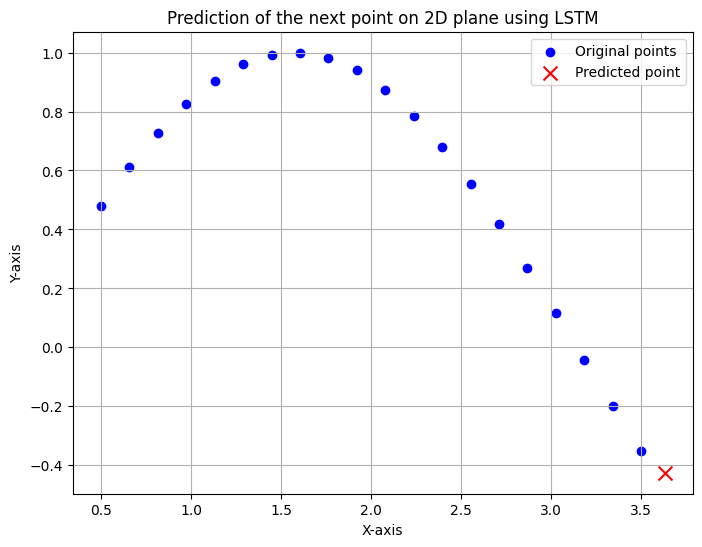

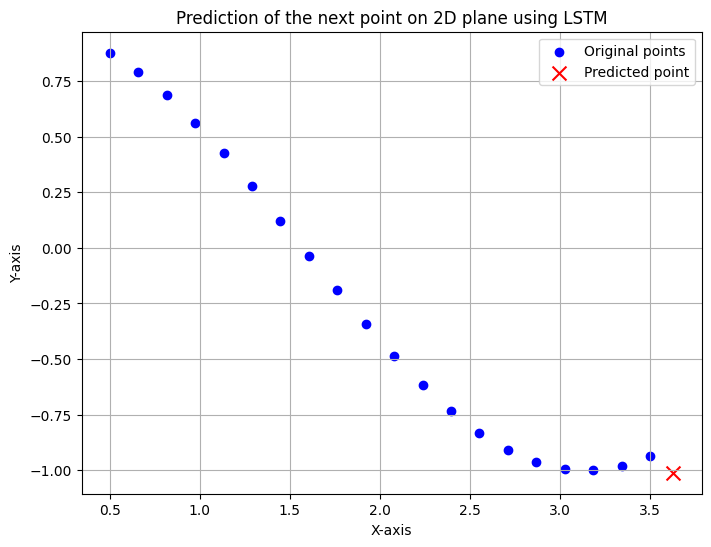

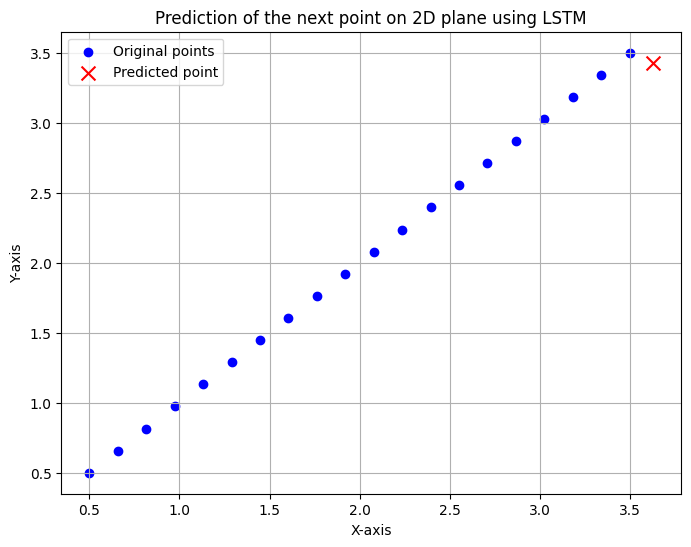

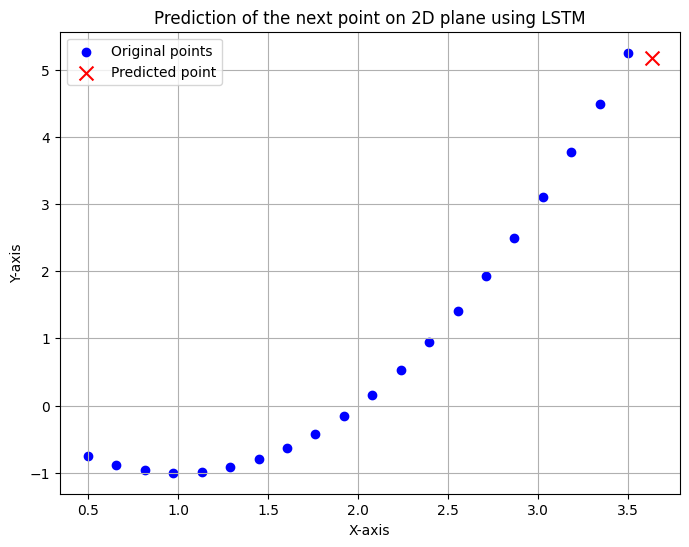

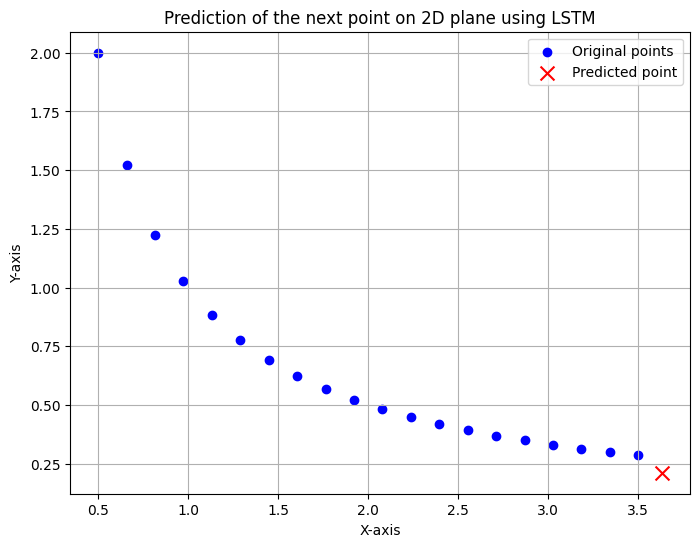

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data: 20 points with sequential movements
# np.random.seed(0)
# num_points = 20
# x = np.linspace(0,4,20)
# points = np.column_stack((x,x*x))
# points_diff = np.diff(points, axis=0)    # Compute displacement between consecutive points

def gen_points(x, expression):
	y = eval(expression)
	return np.column_stack((x,y))

class dataset:
	def gen_data(self, start = 0.5, stop = 3.5, points = 20, expression = "x"):
		self.x = np.linspace(start,stop,points)
		# self.points = []
		self.points = gen_points(self.x, expression)
		self.displacements = np.diff(self.points, axis=0)
	def __init__(self,label = "trajectory", expression = "x"):
		self.label = label
		self.expression = expression
		self.gen_data(expression = self.expression)

train_dataset = [dataset(expression = "np.sin(x)",label = "sin"),
				 dataset(expression = "np.cos(x)",label = "cos"),
				 dataset(expression = "x",label = "liner"),
				 dataset(expression = "x * x -2 *x ",label = "quadratic"),
                         dataset(expression = " 1/x ",label = "verse")
				#  dataset(expression = "np.sigmoid(x-2)",label = "sigmoid")
				 ]

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[-1])  # Only take the output from the last time step
        return output

# Set random seed for reproducibility
torch.manual_seed(0)

# Initialize model, loss function, and optimizer
input_size = 2
hidden_size = 10
output_size = 2
model = LSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    for data in train_dataset:
        points = data.points
        points_diff = data.displacements
        # Prepare data for LSTM
        X = torch.tensor(points_diff[:-1], dtype=torch.float32).unsqueeze(1)  # Input: (num_points-1, 1, 2)
        y = torch.tensor(points_diff[1:], dtype=torch.float32)                 # Target: (num_points-1, 2)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Prediction
model.eval()
with torch.no_grad():
    for data in train_dataset:
        points = data.points
        # Prepare data for LSTM
        X = torch.tensor(points_diff[:-1], dtype=torch.float32).unsqueeze(1)  # Input: (num_points-1, 1, 2)
        future_points_diff = model(X[-1].unsqueeze(0)).squeeze().numpy()
        predicted_point = points[-1] + future_points_diff
        # Visualization
        plt.figure(figsize=(8, 6))
        plt.scatter(points[:, 0], points[:, 1], color='blue', label='Original points')
        plt.scatter(predicted_point[0], predicted_point[1], color='red', label='Predicted point', marker='x', s=100)
        plt.title('Prediction of the next point on 2D plane using LSTM')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.legend()
        plt.grid(True)
        # plt.show()
        # print(f"Predicted point: {predicted_point}")


LSTM with noise, predicting few trajectory

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18, 2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Loss: 0.0029
Epoch [200/1000], Loss: 0.0027
Epoch [300/1000], Loss: 0.0027
Epoch [400/1000], Loss: 0.0028
Epoch [500/1000], Loss: 0.0027
Epoch [600/1000], Loss: 0.0027
Epoch [700/1000], Loss: 0.0027
Epoch [800/1000], Loss: 0.0029
Epoch [900/1000], Loss: 0.0028
Epoch [1000/1000], Loss: 0.0027


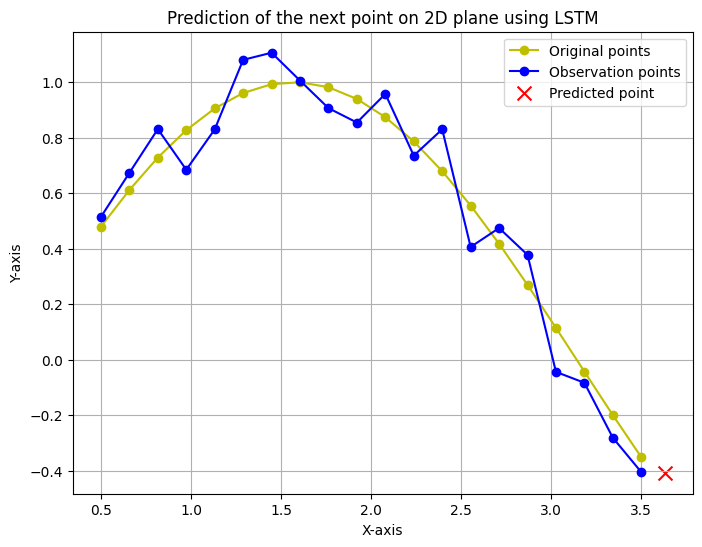

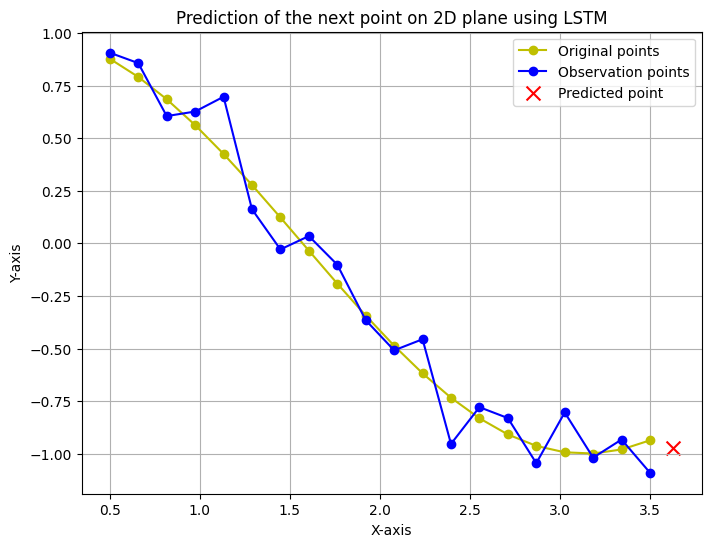

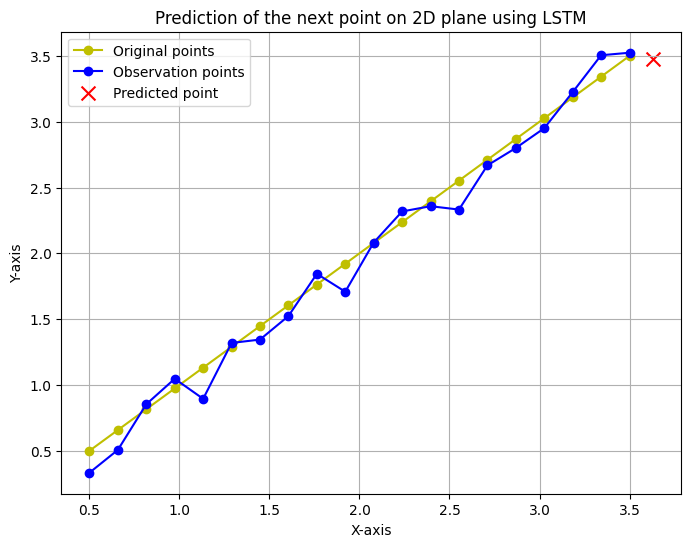

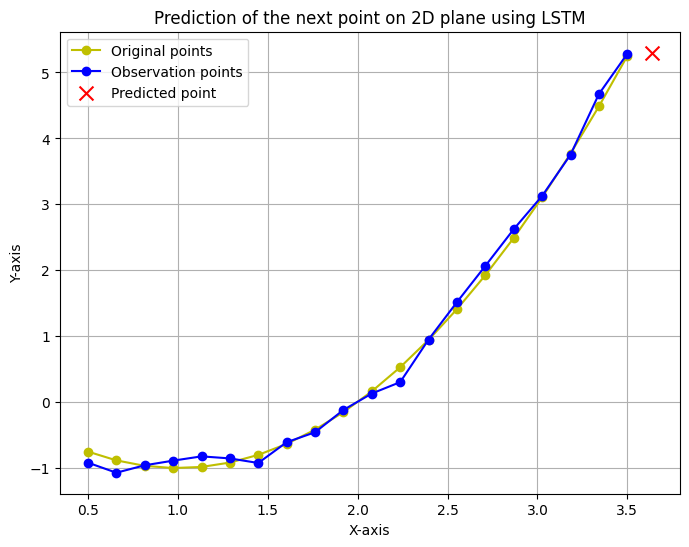

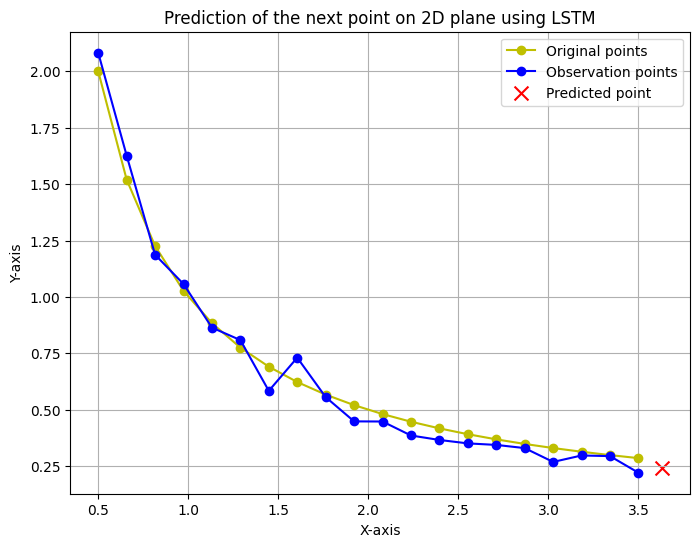

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

#noise geneartion
mean = 0
std_dev = 0.1
noise_size = 1000
gen_noise = np.random.normal(mean, std_dev, noise_size)

def noised(points,is_noised = 1):
    ret_points = points.copy()
    if(is_noised == 0):
      return None,ret_points
    noise = np.random.choice(gen_noise, size=ret_points[:,1].shape)
    ret_points[:,1] = ret_points[:,1] + noise
    return noise, ret_points


def gen_points(x, expression):
	y = eval(expression)
	return np.column_stack((x,y))

class dataset:
	def gen_data(self, start = 0.5, stop = 3.5, points = 20, expression = "x"):
		self.x = np.linspace(start,stop,points)
		# self.points = []
		self.points = gen_points(self.x, expression)
		self.displacements = np.diff(self.points, axis=0)
	def __init__(self,label = "trajectory", expression = "x"):
		self.label = label
		self.expression = expression
		self.gen_data(expression = self.expression)

train_dataset = [dataset(expression = "np.sin(x)",label = "sin"),
				 dataset(expression = "np.cos(x)",label = "cos"),
				 dataset(expression = "x",label = "liner"),
				 dataset(expression = "x * x -2 *x ",label = "quadratic"),
                         dataset(expression = " 1/x ",label = "verse")
				#  dataset(expression = "np.sigmoid(x-2)",label = "sigmoid")
				 ]

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[-1])  # Only take the output from the last time step
        return output

# Set random seed for reproducibility
torch.manual_seed(0)

# Initialize model, loss function, and optimizer
input_size = 2
hidden_size = 10
output_size = 2
model = LSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    for data in train_dataset:
        points = data.points
        points_diff = np.diff(points, axis=0)
        _, points_noisy = noised(points)# 1 noise(default) 0 clean
        points_diff_noisy = np.diff(points_noisy, axis=0)
        # Prepare data for LSTM
        X = torch.tensor(points_diff_noisy[:-1], dtype=torch.float32).unsqueeze(1)  # Input: (num_points-1, 1, 2)
        y = torch.tensor(points_diff[1:], dtype=torch.float32)                 # Target: (num_points-1, 2)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Prediction
model.eval()
with torch.no_grad():
    for data in train_dataset:
        points = data.points
        points_diff = np.diff(points, axis=0)
        _, points_noisy = noised(points)# 1 noise(default) 0 clean
        points_diff_noisy = np.diff(points_noisy, axis=0)
        # Prepare data for LSTM
        X = torch.tensor(points_diff_noisy[:-1], dtype=torch.float32).unsqueeze(1)  # Input: (num_points-1, 1, 2)
        future_points_diff = model(X[-1].unsqueeze(0)).squeeze().numpy()
        predicted_point = points[-1] + future_points_diff
        # Visualization
        plt.figure(figsize=(8, 6))
        plt.plot(points[:, 0], points[:, 1], 'yo-', label='Original points')
        plt.plot(points_noisy[:, 0], points_noisy[:, 1], 'bo-', label='Observation points')
        plt.scatter(predicted_point[0], predicted_point[1], color='red', label='Predicted point', marker='x', s=100)
        plt.title('Prediction of the next point on 2D plane using LSTM')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.legend()
        plt.grid(True)
        # plt.show()
        # print(f"Predicted point: {predicted_point}")


shifting and normalizing (unfinished)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

#noise geneartion
mean = 0
std_dev = 0.1
noise_size = 1000
gen_noise = np.random.normal(mean, std_dev, noise_size)

def noised(points, is_noised = 1):
    ret_points = points.copy()
    if(is_noised == 0):
      return None,ret_points
    noise = np.random.choice(gen_noise, size=ret_points[:,1].shape)
    ret_points[:,1] = ret_points[:,1] + noise
    return noise, ret_points

def shifted(points, is_shift = 1):
    ret_points = points.copy()
    shitf_x = 0.0
    if(is_shift == 0):
      return shift_x, ret_points
    shift_x = ret_points[:,1][-1]
    ret_points[:,1] = ret_points[:,1] - shift_x
    return shift_x, ret_points

def normalized(points, is_normalized = 1):
    ret_points = points.copy()
    norm = 1.0
    if(is_normalized == 0):
      return norm, ret_points
    norm = np.linalg.norm(ret_points[:,1])
    ret_points[:,1] = ret_points[:,1] / norm
    return norm, ret_points

def form_y(points_diff, points_shift,  points_norm):
    ret_points = points_diff.copy()[-1]
    ret_points = ret_points - points_shift
    ret_points = ret_points / points_norm
    return ret_points

def gen_points(x, expression):
	y = eval(expression)
	return np.column_stack((x,y))

class dataset:
	def gen_data(self, start = 0.5, stop = 3.5, points = 20, expression = "x"):
		self.x = np.linspace(start,stop,points)
		# self.points = []
		self.points = gen_points(self.x, expression)
		self.displacements = np.diff(self.points, axis=0)
	def __init__(self,label = "trajectory", expression = "x"):
		self.label = label
		self.expression = expression
		self.gen_data(expression = self.expression)

train_dataset = [dataset(expression = "np.sin(x)",label = "sin"),
				 dataset(expression = "np.cos(x)",label = "cos"),
				 dataset(expression = "x",label = "liner"),
				 dataset(expression = "x * x -2 *x ",label = "quadratic"),
                 dataset(expression = " 1/x ",label = "verse"),
                 dataset(expression = "2 / x", label = "verse2"),
                 dataset(expression = "10086 / x", label = "verse3")
				#  dataset(expression = "np.sigmoid(x-2)",label = "sigmoid")
				 ]

# 检查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        lstm_out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(lstm_out[:, -1, :])  # 只取最后一个时间步的输出
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Set random seed for reproducibility
torch.manual_seed(0)

# Initialize model, loss function, and optimizer
input_size = 4
hidden_size = 50  # Increased hidden size
output_size = 2
num_layers = 3  # Increased number of layers
dropout = 0.3  # Dropout rate

model = LSTM(input_size, hidden_size, output_size, num_layers, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 降低学习率


# Training the model
num_epochs = 20000
for epoch in range(num_epochs):
    for data in train_dataset:
        points = data.points
        points_diff = np.diff(points, axis=0)
        _, points_noised = noised(points)# 1 noise(default) 0 clean
        points_shift_x, points_shifted = shifted(points_noised)# 1 shift(default) 0 no shift
        points_shift_x = np.array([points_shift_x])
        points_norm, points_normalized = normalized(points_shifted)# 1 normalize(default) 0 no normalize
        points_norm = np.array([points_norm])
        points_diff_ = np.diff(points_normalized, axis=0)

        # Repeat points_shift_x and points_norm to match the shape of points_diff_
        points_shift_x_repeated = np.repeat(points_shift_x, points_diff_.shape[0], axis=0)
        points_norm_repeated = np.repeat(points_norm, points_diff_.shape[0], axis=0)
        # Expand the dimensions of points_shift_x and points_norm
        points_shift_x_repeated = np.expand_dims(points_shift_x_repeated, axis=1)
        points_norm_repeated = np.expand_dims(points_norm_repeated, axis=1)

        # Concatenate along the feature dimension
        combined_input = np.concatenate((points_diff_[:-1], points_shift_x_repeated[:-1], points_norm_repeated[:-1]), axis=1)

        # Prepare data for LSTM
        X = torch.tensor(combined_input, dtype=torch.float32).unsqueeze(1).to(device)  # Input: (num_points-1, 1, 2)
        y = torch.tensor(points_diff[1:], dtype=torch.float32).to(device)                 # Target: (num_points-1, 2)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Prediction
model.eval()
with torch.no_grad():
    for data in train_dataset:
        points = data.points
        points_diff = np.diff(points, axis=0)
        _, points_noised = noised(points)# 1 noise(default) 0 clean
        points_shift_x, points_shifted = shifted(points_noised)# 1 shift(default) 0 no shift
        points_shift_x = np.array([points_shift_x])
        points_norm, points_normalized = normalized(points_shifted)# 1 normalize(default) 0 no normalize
        points_norm = np.array([points_norm])
        points_diff_ = np.diff(points_normalized, axis=0)

        # Repeat points_shift_x and points_norm to match the shape of points_diff_
        points_shift_x_repeated = np.repeat(points_shift_x, points_diff_.shape[0], axis=0)
        points_norm_repeated = np.repeat(points_norm, points_diff_.shape[0], axis=0)
        # Expand the dimensions of points_shift_x and points_norm
        points_shift_x_repeated = np.expand_dims(points_shift_x_repeated, axis=1)
        points_norm_repeated = np.expand_dims(points_norm_repeated, axis=1)

        # Concatenate along the feature dimension
        combined_input = np.concatenate((points_diff_[:-1], points_shift_x_repeated[:-1], points_norm_repeated[:-1]), axis=1)
        # Prepare data for LSTM
        X = torch.tensor(combined_input, dtype=torch.float32).unsqueeze(1)  # Input: (num_points-1, 1, 2)
        future_points_diff = model(X[-1].unsqueeze(0)).squeeze().numpy()
        predicted_point = points[-1] + future_points_diff
        # Visualization
        plt.figure(figsize=(8, 6))
        plt.plot(points[:, 0], points[:, 1], 'yo-', label='Original points')
        plt.plot(points_noised[:, 0], points_noised[:, 1], 'bo-', label='Observation points')
        plt.scatter(predicted_point[0], predicted_point[1], color='red', label='Predicted point', marker='x', s=100)
        plt.title('Prediction of the next point on 2D plane using LSTM')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.legend()
        plt.grid(True)
        # plt.show()
        # print(f"Predicted point: {predicted_point}")


Epoch [10000/20000], Loss: 285815.3438
